<a href="https://colab.research.google.com/github/adrianmarino/12-RNN/blob/master/lstm_and_time_distributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando TimeDistributed con LSTM's

## One to One

In [0]:
%matplotlib inline

In [0]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed

from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

### Funciones axiliares

Estas son funiones para no mostrar código repetido en los ejemplos. Recomiendo analizarlas cuando lleguemos al momento de utilizarlas, ante no por que es tratar de entender las cosas al revéz.


In [0]:
def show(model): 
  model.summary()
  dot_mode = model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg')
  display(SVG(dot_mode))


def create_model(
    input_shape, 
    hidden_neurons, 
    output_neurons,
    use_time_distributed=False
):
  model = Sequential()
  model.add(LSTM(
      hidden_neurons, 
      input_shape=input_shape, 
      return_sequences=use_time_distributed
  ))
  
  output = Dense(output_neurons)
  if use_time_distributed:
    output = TimeDistributed(output)    
  
  model.add(output)
  
  model.compile(loss='mean_squared_error', optimizer='adam')
  show(model)
  return model


def train(model, X, y, epochs, batch_size):
  history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
  loss = history.history['loss'][-1]
  print(f'Loss: {loss}')

###  Prepare samples (input/output data)

Primero generamos una array de 5 valores:

In [93]:
length = 5
sequence = array([index/float(length) for index in range(length)])
print(f'Seq: {sequence}')

Seq: [0.  0.2 0.4 0.6 0.8]


Ahora, como es un toy example la red va a hacer un echo(Eco), si entra un cero sale un cero y asi sucesivamente. Pero como vamos a entranar una RNN necesitamos que cada ejemplo de input tenga el formato **(N, T, D)**. 

**LSTM**: Es un RNN con mas memoria que una SimpleRNN, es decir, recuerda secuencias mucho mas largas. 

¿Pero que es esto?
* N: Número de ejemplos presentados a la red.
* T: Es la secuencia de datos que se van a pasar por cada ejemplo N.
* D: Es la dimesionalidad de cada elemento en la secuencia. Por ejemplo: En este caso estamos pasando números. Un número se puede representar con un solo valor D=1, pero hay casos muy comunes donde la representación puede cambiar, por ejemplo con palabras.

* En este caso tenemos 5 ejemplos: [ 0, 0.2, 0.4, 0.6, 0.8] => N=5.
* En general con RNN uno quiere predecir el siguiente valor de una secuencia. Por ejemplo, tengo los ultimos 3(T=3) valores [ 0, 0.2, 0.4] y quiero predecir el siguente(0.6). En nuestro caso la secuencia es T=1 por que solo queremos hacer un eco, por eso no tiene sentido usar RNN, con una densa seria lo mismo.
* Cada valor de la secuencia se puede representar con una unica dimensión, ya que es un numero. Entonces D=1

Input Shape: **(N, T, D)** = (5, 1, 1)

¿Y en la salida que le ponemos?

la forma de la salida seria (N, D) ya que a la red se le presentan N=5 ejemplos los cuales tiene una dimensión de 1 valor numerico.

Output Shape: **(N, D)** = (5, 1)

In [94]:
X = sequence.reshape(len(sequence), 1, 1)
print(f'X {X.shape}: {X}')

y = sequence.reshape(len(sequence), 1)
print(f'y {y.shape}: {y}')

X (5, 1, 1): [[[0. ]]

 [[0.2]]

 [[0.4]]

 [[0.6]]

 [[0.8]]]
y (5, 1): [[0. ]
 [0.2]
 [0.4]
 [0.6]
 [0.8]]


### Define LSTM configuration

In [95]:
input_shape=(1,1)
print(f'input_shape: {input_shape}')


hidden_neurons = 3
print(f'hidden_neurons: {hidden_neurons}')

output_neurons = 1
print(f'output_neurons: {output_neurons}')

batch_size = length
print(f'batch_size: {batch_size}')

epochs = 1000
print(f'epochs: {epochs}')

input_shape: (1, 1)
hidden_neurons: 3
output_neurons: 1
batch_size: 5
epochs: 1000


Ahora analicemos mejorlos parametros:

####  ¿Porque 5 neuronas ocultas?

En realidad este numero no tiene ninguna relacion con el N=5. no la busquen por que no la hay!. El numero de neuronas ocultas es arbitrario, se elige lo que mejor funciona pero: 

¿Hay alguna forma de elegir elmenor numero de neuronas que minimize el numero de parametros de la red?

Al parecer hay una forma de calcularlo pero es una aplroximación, una guia:

>$ 𝑁ℎ=𝑁𝑠 / (𝛼∗(𝑁𝑖+𝑁𝑜))$

Donde:
* $𝑁h$ = El lo que queremos averiguar, el número de neuronas de oa capa oculata de la LSTM. 
* $𝑁i$ = El número de neuronas de entrada (Que seria el tamaño de la secuencia T)
* $𝑁𝑜$ = El número de neuronas de salida (La dimencionalidad?).
* $𝑁𝑠$ = El número de ejemplos de entrenamiento(En nuestro ejemplo es N=5). 
* $𝛼$ = Es un factor de escala arbitrario entre 2 y 10.

Pero mas alla de esta explicación: ** No hay reglas claras para elegir el numero de neuronas acoltas, es algo que se descubre con prueba y error y depeden del problema a resolver.**

[Ver Referencia](https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm)

####  ¿Por que batch_size=5?

Sabemos que una RNN  decide su salida actual en base al input actual y tambien a los inputs anteriores. Esto quiere decir que la red garda estado. Ahora bien, al momento de entranar la red sabemos que el estado no se conserva entre batches. si el batch size fuese 1 no tendria serntido usar una RNN ya que no importaria el orden en que se le muestran los ejemplos y nuevamente seria lo mismo que usar una red Densa.

####  ¿Por que una reurona de salida?

Como hablamos, que ingrear cada valor por separado y tener un valor de salida por eso tenemos una nerona de salida. Cada salida representa un valor.

####  ¿Por que input_shape=(1,1)?

input_shapr es la forma que tienecada ejemplo en la entrada de la capa. En caso cada ejemplo
tiene una secuencia de 1 valor y cada valor tiene una dimensionalidad de 1.

input_shape=**(T, D)**


####  ¿Por que epochs=1000?
Esto tambien es arbitrario, pero la regla es elegir el menor numero de epochs para el cual se llegue al resultado esperado. 
Es decir, en este caso con 1000 epochs el resultado es el esperado. Si elegimos 10.000 estamos mejorando el error pero es necesario? El resutlado no seria el mismo?

### Create LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 3)                 60        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


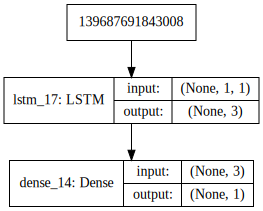

In [96]:
model = create_model(input_shape, hidden_neurons, output_neurons)

### Train LSTM

In [97]:
train(model, X, y, epochs, batch_size)

Loss: 0.00012466800399124622


### Evaluate

In [98]:
predictions = model.predict(X, batch_size=batch_size, verbose=0)

inputs = ["%.1f" % x for x in X]
outputs = ["%.1f" % output for output in predictions]

print(f'Inputs: {inputs}\nOutputs: {outputs}')

Inputs: ['0.0', '0.2', '0.4', '0.6', '0.8']
Outputs: ['0.0', '0.2', '0.4', '0.6', '0.8']


## Many to One

La idea en este caso es tomar como entradas toda la seguencia y en la salida tener toda la secuencia, todo en un solo paso a diferencia del caso anterior.

### Dimensionalidad de entrada

* N=1: Entonces si pasamos la secuencia completa en un solo paso, vamos a tener un solo ejemplo.
* T=5: Este unico ejemplo tiene una secuencia (temporal) de tamaño 5.
* D=1: La dimencionalidad del cada elemento de la secuenca no cambia, por que seguimos trabajando con numeros que se pueden representar en un solo valor ,como hablamos anteriormente.

=> **(N, T, D)** = (1, 5, 1)

### Dimensionalidad de salida

=> **(N, T)** = (1, 5)

* N=1: Solo hay un ejemplo, por o tanto habra un solo resultados a la salida.
*T=5. Cada elemento de salida tiene 5 valores, uno por cada elemento en la secuencia de entrada.


Una cosa a tener en cuenta es que N es *variable**! Es la cantidad de ejemplos que le pasamos a la red para entrenar. Osea, podriamos pasar mas o menos ejemplos. 
Por esta cuestion cuando hacemos model.summary() N aparece como **None**.Se refiere a que dimensión no esta definida. Osea, la red no tiene una restricción en el número de ejemplos a pasar. N es 1 para este ejemplo, por que no tenemos mas datos.

In [99]:
X = sequence.reshape(1, 5, 1)
print(f'X {X.shape}: {X}')

y = sequence.reshape(1, 5)
print(f'y {y.shape}: {y}')

X (1, 5, 1): [[[0. ]
  [0.2]
  [0.4]
  [0.6]
  [0.8]]]
y (1, 5): [[0.  0.2 0.4 0.6 0.8]]


In [100]:
input_shape=(5, 1)
print(f'input_shape: {input_shape}')

hidden_neurons = 3
print(f'hidden_neurons: {hidden_neurons}')

output_neurons = 5
print(f'output_neurons: {output_neurons}')

batch_size = 1
print(f'batch_size: {batch_size}')

epochs = 500
print(f'epochs: {epochs}')

input_shape: (5, 1)
hidden_neurons: 3
output_neurons: 5
batch_size: 1
epochs: 500


Buen aca cambiaron alguna cosas:

#### ¿Porque input_shape=(5, 1)?
 
En este caso cada ejemplo tiene una secuenca de 5 valores y cada valor una dimensión 1.

#### ¿Por que 3 neuronas ocultas?

Como ya aclaramos en el caso anterior, este numero es arbrario, se elije lo que mejor fucione, pero buscando el número mas bajo con el cual se tenga buenos resultados.

#### ¿Por que 5 neuronas de salida?

Bueno, la idea es ingresar un ejemplo con una secuencia de 5 valores y a la salida tener un eco de estos mismo 5 valores, asi que necesitamos 5 salidas.

####  ¿Por que batch_size=1?

Bueno acá hay un **tema importante a aclarar**. No nos olvidemos que estamos trabajando con redas neuronales recurrentes. Como sabemos, estas infieren la salida por que recuerdan entradas anteriores, ya que poseen una memoria que puede ser mayor o menor, dependiendo de la implementación que usemos (LSTM, SimpleRNN, GRU, etc...).

Ahora bien, para tener memoria, la red tiene un estado. Al momento de entranar la red podemos elegir cuando resetear este estado interno. Por defecto, Keras resetea el estado al comenzar cada batch de ejemplos. Si por alguna razón queremos modificar este comportamiento podemos utilizar el atributo statefull de keras.

* stateful = True :  En este caso al finalizar el entrenamiento del último ejemplo de un batch de entrenamiento se toma ese estado y se lo pone a la entrada antes de procesar el primer ejemplo del siguiente batch. Es decir, lo que hace es conservar el estado de la red entre batches. Luego una puede resetear ese estado en el momento que se quiera. 


* stateful = False: Es el valor por defecto y en este caso no se conserva el estado entre batches. 

Si razonamos un poco, podemos entender que el batch_size seria el número de ejemplo que
queremos que la red recuede si statefull=False. Si statefull=True, esto se modifica dependeiendo que cuando hagamos el reset de la red. Pero se entiende que seria una forma de modificar el número de ejemplos que que pue memorizar la red. Ahora bien, esto me parece que no hay que tomarlo en sentido estricto ya que no sabemos cuando recuerda la red, creo que es algo que depende del problema a resolver.

Por esta cuestión el batch_size elegido es 1. Ya que no hace falta guardar el estado mas alla de los 5 valores.


####  ¿Por que epochs=500?

Bueno en este caso como se le pasa toda la secuencia a la red necesitamenos iteraciones para llegar al resultado esperado.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 3)                 60        
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


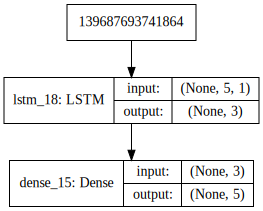

In [101]:
model = create_model(input_shape, hidden_neurons, output_neurons)

In [102]:
train(model, X, y, epochs, batch_size)

Loss: 2.943455701398534e-09


In [103]:
predictions = model.predict(X, batch_size=batch_size, verbose=0)


inputs = ["%.1f" % x for x in X[0]]
outputs = ["%.1f" % y for y in predictions[0]]
print(f'Inputs: {inputs}\nOutputs: {outputs}')

Inputs: ['0.0', '0.2', '0.4', '0.6', '0.8']
Outputs: ['0.0', '0.2', '0.4', '0.6', '0.8']


#### Conclusiones hasta el momento

Hasta acá, podemos ver la cantidad de parametros de la LSMT no cambio. Osea, que si cambio el tamaño de la secuencia en una LSTM no cambia el número de sus hiperparametros, lo cual es un punto positivo. 

Por otro lado, podemos ver que la capa densa de salida si cambio. Ahora tenemos mas parametros a entrenar: 29 pesos + un bias.

Otro tema a tener en cuenta, es que podriamos haber usado una cadadensa es vez de una LSTM, ya que en este ejemplo no estamos usando la memoria que tiene la LSTM entre ejemplos. con una densa de 5 entradas era suficiente.


## Many-to-Many con wrapper TimeDistributed

In [104]:
X = sequence.reshape(1, 5, 1)
print(f'X {X.shape}: {X}')

y = sequence.reshape(1, 5)
print(f'y {y.shape}: {y}')

X (1, 5, 1): [[[0. ]
  [0.2]
  [0.4]
  [0.6]
  [0.8]]]
y (1, 5): [[0.  0.2 0.4 0.6 0.8]]


In [118]:
input_shape=(5, 1)
print(f'input_shape: {input_shape}')

hidden_neurons = 3
print(f'hidden_neurons: {hidden_neurons}')

output_neurons = 1
print(f'output_neurons: {output_neurons}')

batch_size = 1
print(f'batch_size: {batch_size}')

epochs = 100
print(f'epochs: {epochs}')

input_shape: (5, 1)
hidden_neurons: 3
output_neurons: 1
batch_size: 1
epochs: 100


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 5, 3)              60        
_________________________________________________________________
time_distributed_9 (TimeDist (None, 5, 1)              4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


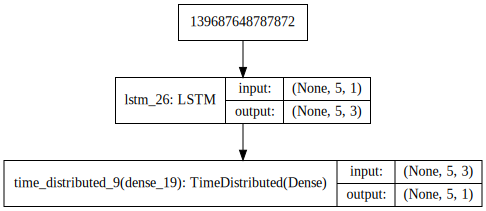

In [119]:
model = create_model(input_shape, hidden_neurons, output_neurons, use_time_distributed=True)

Bueno aca hay varias cosas nuevas:

1. use_time_distributed=True: Este parametro esta haciendo dos cosas muy importante al momento de construir el modelo:
  * Primero configura la capa LSTM para que retorne todas las salidad de la red(return_sequences=True) . Recordemos que un LSTM tiene una salida por cada elemento de la secuencia de entreada. Si tenemos una secuencia de 5, tenemos 5 steps en la red y cada uno tiene una salida. En este caso entonces la LSTM tiene 5 entradas y 5 salidas. Luego, cada salida tiene la dimensión igual al número de neuronas ocultas, que en este caso es 3. Cabe destacar que  con return_sequences=False se toma la salida del step 5 (último) de la LSTM.
  * Segundo, se agrego una capa que envuelve(wrapea) la capa densa de salida. Lo que hace esta capa, es repetirla la capa densa por cada salida de la LSTM, pero con la condición de que los pesos de la densa se compartan entre todas las salida. Es decir que si la secuencia de 100 en vez de 5 , la cantidad de parametro no cambia, otro punto positivo.
 
 2. El número de salidas que elegimos para la capa densa era 1, pero se puede ver que al usar la capa TimeDistributed se modifico la salida, ya que al tener una densa por cada salida de la LSTM, ahora la red tiene 5 salida en vez de una.



## Conclusiones finales

Saquemos conclusiones ahora que vimos todos los ejemplos:

* En este último ejemplo tenemos la misma dimensionalidad que el primer, pero a su favor, permite manejar las secuencias de una forma mas natural que el pimer caso, donde tenemos que entrenar la red pasando cada valor de la secuencia por separado.

* Por otro lado se simplifica la red. El ejemplo many-one  tiene la misma dimensionalidad de entrada y salida que este ultimo ejemplo, pero la diferencia importante es que bajamos el numero de parametros a entrenar. Esto se traduce en menor uso de recursos y menor tiempo de entrenamiento.